In [1]:
import pandas as pd
import numpy as np
import json
import nltk
import re
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [2]:
%matplotlib inline
pd.set_option('display.max_colwidth', 300)

In [3]:
meta = pd.read_csv('Articoli Taggati v7.csv', sep=";", skipinitialspace = True, quotechar='"')

In [4]:
#meta.head()

In [5]:
meta.columns

Index(['Unnamed: 0', 'ID', 'Titolo', 'Data', 'Trend', 'Anno', 'Mese', 'Txt',
       'Keywords', 'Tags', 'Tag', 'Tech', 'Location', 'Company', 'People',
       'Application', 'Vertical'],
      dtype='object')

In [6]:
articoli_data = meta.groupby(["Trend", "Mese"]).size().reset_index(name="Count")

In [7]:
articoli_data.head()

,Trend,Mese,Count
0,3D Printing and New Materials,3.0,1
1,3D Printing and New Materials,4.0,3
2,3D Printing and New Materials,5.0,3
3,AI Ethics and Unbiasing,3.0,2
4,AI Ethics and Unbiasing,4.0,14


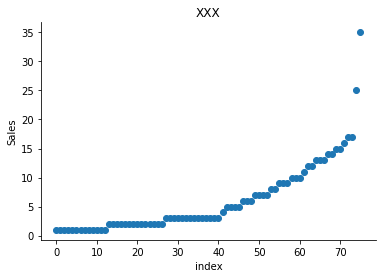

In [8]:
plt.scatter(range(articoli_data.shape[0]), np.sort(articoli_data['Count'].values))
plt.xlabel('index')
plt.ylabel('Sales')
plt.title("XXX")
sns.despine()

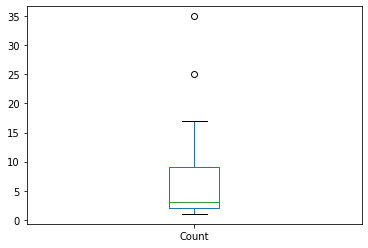

In [9]:
# Generate a Boxplot
articoli_data['Count'].plot(kind='box')
plt.show()

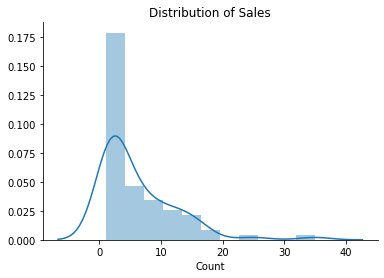

In [10]:
sns.distplot(articoli_data['Count'])
plt.title("Distribution of Sales")
sns.despine()

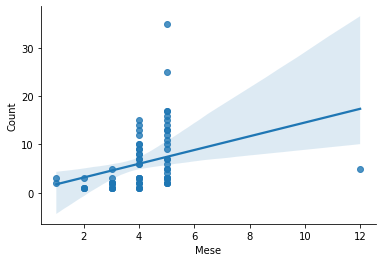

In [11]:
sns.regplot(x="Mese", y="Count", data=articoli_data)
sns.despine();

In [12]:
articoli = meta[['ID','Trend', 'Tags', 'Anno', 'Mese']]
articoli.head()

,ID,Trend,Tags,Anno,Mese
0,c812e0a3418d624ae60df3ec9e19d184,Robotics and Human/Machine Hybridization,Tech: Drones,2020.0,4.0
1,0e2ef6bd7619374e0531d1551ab2141e,Privacy and Security by design,"Vertical: Advertising, Company: Adobe",2020.0,4.0
2,8602d8791a1754506303dcfd9a7b79e3,Cyber Defense and Fight against Fakes,NaN,2020.0,5.0
3,2157ac6d12e063b6a38c5c0491e0b322,Workforce Transformation,Tag: Future,2020.0,5.0
4,89390733d3f9e1f30bae53de5e2d8a04,New Normal after COVID-19,NaN,2020.0,5.0


In [13]:
ds = articoli.set_index(['Trend', 'Mese', 'Anno']).Tags.str.split(',',expand=True).stack().reset_index().loc[:, ['Trend','Anno', 'Mese', 0]].rename({0: 'Tag'}, axis='columns')
ds.head()

,Trend,Anno,Mese,Tag
0,Robotics and Human/Machine Hybridization,2020.0,4.0,Tech: Drones
1,Privacy and Security by design,2020.0,4.0,Vertical: Advertising
2,Privacy and Security by design,2020.0,4.0,Company: Adobe
3,Workforce Transformation,2020.0,5.0,Tag: Future
4,Health Tech,2020.0,4.0,Company: Apple


In [14]:
tags_for_trend = ds.groupby(["Trend", "Tag"]).size().reset_index(name="Count").groupby(['Trend'])['Tag'].apply(', '.join).reset_index()

In [15]:
def deduplica(text):
    str_list = text.split(",")
    str_list = list(map(str.strip, str_list))
    str_list = list(filter(None, str_list))
    str_list = list(set(str_list))
   
    str_list = ", " . join(str_list)
    return str_list
    
deduplica(tags_for_trend['Tag'][3])

tags_for_trend['Tag'] = tags_for_trend['Tag'].apply(lambda x: deduplica(x))

In [16]:
tags_for_trend.head()

,Trend,Tag
0,3D Printing and New Materials,"Vertical: Energy, Vertical: Food, Tech: Artificial Intelligence"
1,AI Ethics and Unbiasing,"Company: Amazon, Company: Bayer, Location: China, Application: Data Science, Vertical: Sports, Tech: Artificial Intelligence, Vertical: Advertising, Application: Personal Assistant"
2,Augmented Intelligence through ML and DL,"Vertical: Automotive, Tech: Augmented Reality, Tech: Mobile app, Application: Driverless Vehicles, Application: Deep Fakes, Application: Personal Assistant, Application: Contact Center, Vertical: Finance, Application: E-Commerce, Company: Amazon, Location: Boston, Tech: Cloud, Application: Cyber..."
3,Blockchain and Cryptocurrencies,"Company: Amazon, Application: Renewables, Company: Microsoft, Tech: Blockchain, Vertical: Banking, Tech: Cloud, Vertical: Finance, Application: Cryptocurrencies, Vertical: Energy, Application: Digitalization"
4,Circular Economy Sustainability and Zero Impact Economy,"Application: Renewables, Application: Advanced Analytics, Vertical: Agricolture, Vertical: Aviation, Vertical: Biology, Vertical: Food, Vertical: Energy, Location: Africa, Vertical: Fashion"


In [17]:
df = ds.groupby(["Anno", "Mese", "Trend"]).size().reset_index(name="Count")
df["Data"] = df["Anno"].astype(int).astype(str) + df["Mese"].astype(str)
del(df['Anno'])
del(df['Mese'])
df.head()

,Trend,Count,Data
0,Future of Mobility,2,201912.0
1,Future of Mobility,2,20201.0
2,Sensors and Smart Things,3,20201.0
3,Customer Experience and Human-centered Design,3,20202.0
4,Fintech and future of economy,2,20202.0


In [18]:
df.loc[df['Trend'] == "Sensors and Smart Things"]

,Trend,Count,Data
2,Sensors and Smart Things,3,20201.0
6,Sensors and Smart Things,1,20202.0
37,Sensors and Smart Things,2,20204.0
66,Sensors and Smart Things,1,20205.0


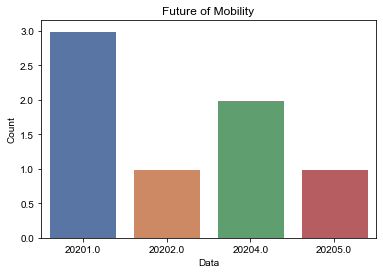

In [19]:
plt.title("Future of Mobility")

sns.set(rc={'figure.figsize':(13,8)})
sns.barplot(x="Data", y="Count", data=df.loc[df['Trend'] == "Sensors and Smart Things"])

In [20]:
articles_per_trend = meta.groupby("Trend").size().reset_index(name="Count")
articles_per_trend = articles_per_trend.sort_values("Count", ascending=False)
articles_per_trend.head()

,Trend,Count
21,New Normal after COVID-19,46
16,Future of Mobility,43
6,Cyber Defense and Fight against Fakes,30
13,Fintech and future of economy,27
2,Augmented Intelligence through ML and DL,26


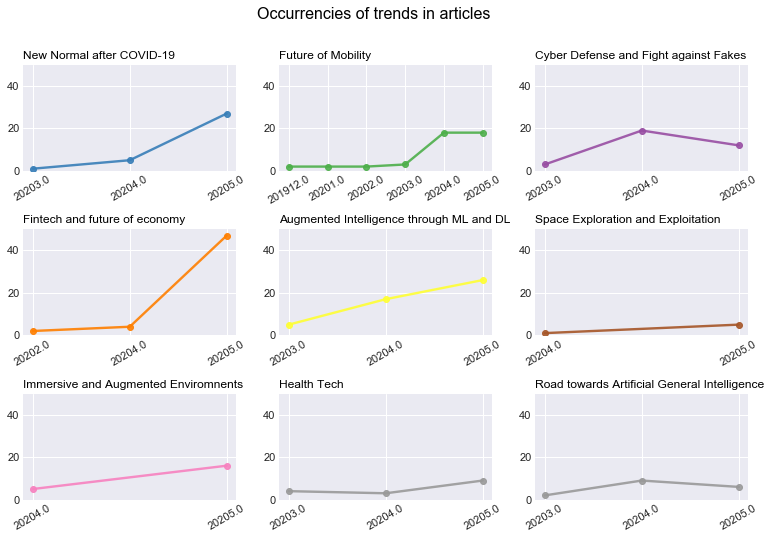

In [21]:
# https://python-graph-gallery.com/125-small-multiples-for-line-chart/

# Initialize the figure
plt.style.use('seaborn-darkgrid')

# create a color palette
palette = plt.get_cmap('Set1')

n = 0
trends = articles_per_trend["Trend"].unique()
for i in trends:
    n+=1

    d = df.loc[df['Trend'] == i]
    plt.subplot(3,3, n)
    plt.ylim(0,50)
    plt.plot(d['Data'], d['Count'], marker='o', color=palette(n), linewidth=2.4, \
             alpha=0.9, label=i)
    plt.xticks(rotation=30)
    plt.title(i, loc='left', fontsize=12, fontweight=0, color="black" )
    
    if n == 9:
        break

# general title
plt.suptitle("Occurrencies of trends in articles", fontsize=16, fontweight=0, color='black')
plt.subplots_adjust(hspace=0.55)

In [22]:
articles_per_vertical = meta.groupby("Vertical").size().reset_index(name="Count")
articles_per_vertical = articles_per_vertical.sort_values("Count", ascending=False)

In [23]:
df = meta.groupby(["Anno", "Mese", "Vertical"]).size().reset_index(name="Count")
df["Data"] = df["Anno"].astype(int).astype(str) + df["Mese"].astype(str)
del(df['Anno'])
del(df['Mese'])
df.head()

,Vertical,Count,Data
0,Automotive,2,201912.0
1,Banking,1,20202.0
2,Fintech,1,20202.0
3,Advertising,1,20203.0
4,Automotive,1,20203.0


19


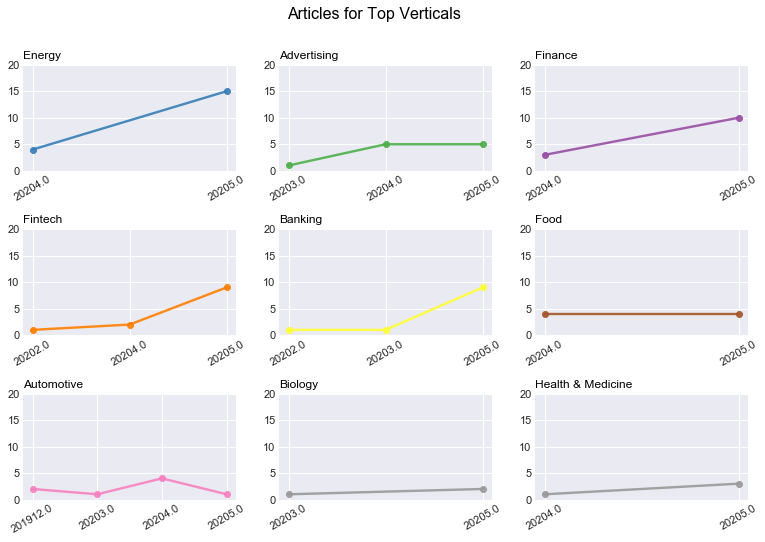

In [27]:
# https://python-graph-gallery.com/125-small-multiples-for-line-chart/

# Initialize the figure
plt.style.use('seaborn-darkgrid')

# create a color palette
palette = plt.get_cmap('Set1')

n = 0
vertical = articles_per_vertical["Vertical"].unique()
print (len(vertical))
for i in vertical:
    n+=1

    d = df.loc[df['Vertical'] == i]
    plt.subplot(3,3, n)
    plt.ylim(0,20)
    plt.plot(d['Data'], d['Count'], marker='o', color=palette(n), linewidth=2.4, \
             alpha=0.9, label=i)
    plt.xticks(rotation=30)
    plt.title(i, loc='left', fontsize=12, fontweight=0, color="black" )
    
    if n == 9:
        break

# general title
plt.suptitle("Articles for Top Verticals", fontsize=16, fontweight=0, color='black')
plt.subplots_adjust(hspace=0.55)